In [421]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import json
import requests
import pymongo

In [14]:
# Connect to database
conn = sqlite3.connect('''database.sqlite''')

# Create cursor object
cur = conn.cursor()

In [15]:
# View Matches dataframe

cur.execute('''SELECT * FROM Matches;''')
Matches_df =pd.DataFrame(cur.fetchall())
Matches_df.columns = [x[0] for x in cur.description]
Matches_df.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1,D2,2009,2010-04-04,Oberhausen,Kaiserslautern,2,1,H
1,2,D2,2009,2009-11-01,Munich 1860,Kaiserslautern,0,1,A
2,3,D2,2009,2009-10-04,Frankfurt FSV,Kaiserslautern,1,1,D
3,4,D2,2009,2010-02-21,Frankfurt FSV,Karlsruhe,2,1,H
4,5,D2,2009,2009-12-06,Ahlen,Karlsruhe,1,3,A


In [16]:
# View Teams dataframe

cur.execute('''SELECT * FROM Teams;''')
Teams_df = pd.DataFrame(cur.fetchall())
Teams_df.columns = [x[0] for x in cur.description]
Teams_df.head()

,Season,TeamName,KaderHome,AvgAgeHome,ForeignPlayersHome,OverallMarketValueHome,AvgMarketValueHome,StadiumCapacity
0,2017,Bayern Munich,27,26,15,597950000,22150000,75000
1,2017,Dortmund,33,25,18,416730000,12630000,81359
2,2017,Leverkusen,31,24,15,222600000,7180000,30210
3,2017,RB Leipzig,30,23,15,180130000,6000000,42959
4,2017,Schalke 04,29,24,17,179550000,6190000,62271


In [17]:
# View Teams_in_Matches dataframe

cur.execute('''SELECT * FROM Teams_in_Matches;''')
Teams_in_Matches_df = pd.DataFrame(cur.fetchall())
Teams_in_Matches_df.columns = [x[0] for x in cur.description]
Teams_in_Matches_df.head()

,Match_ID,Unique_Team_ID
0,1,26
1,1,46
2,2,26
3,2,42
4,3,26


In [18]:
# View Unique_Teams dataframe

cur.execute('''SELECT * FROM Unique_Teams;''')
Unique_Teams_df = pd.DataFrame(cur.fetchall())
Unique_Teams_df.columns = [x[0] for x in cur.description]
Unique_Teams_df.head()

,TeamName,Unique_Team_ID
0,Bayern Munich,1
1,Dortmund,2
2,Leverkusen,3
3,RB Leipzig,4
4,Schalke 04,5


In [177]:
# View Matches from 2011 season

cur.execute('''SELECT * FROM Matches WHERE Season = '2011';''')
Matches_2011_df =pd.DataFrame(cur.fetchall())
Matches_2011_df.columns = [x[0] for x in cur.description]
Matches_2011_df.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D


In [180]:
Matches_2011_df.Date.nunique()

165

# DarkSky API WeatherGetter

The below class will take in a list of dates and get the weather in Berlin on that date. It will also produce each teams percentage of wins that occured in the rain.

In [409]:
class WeatherGetter:
    
    def __init__(self):
        self.path = "/Users/erikadauria/Flatiron/Projects/Soccer_in_the_Rain/.secret/darksky_api.json"
        self.url = 'https://api.darksky.net/forecast/'
        self.berlin_latitude = '52.520008'
        self.berlin_longitude = '13.404954'
        self.exclude = '?exclude=minutely,hourly,currently,flags,alerts'
    
    def get_key(self):
        with open(self.path) as f:
            key = json.load(f)
            self.api_key = key['api_key']
            return self.api_key
    
    def get_weather(self, day):
        api_key = self.get_key()
        date = day+'T12:00:00'
        request_string = '{}{}/{},{},{}{}'.format(self.url, api_key, self.berlin_latitude, self.berlin_longitude, date,self.exclude)
        response = requests.get(request_string)
        self.weather = response.json()['daily']['data'][0]['icon']
        return self.weather
    
    def get_weather_for_all_days(self, dates):
        self.weather_df = pd.DataFrame(dates, columns = ['Date'])
        self.weather_df['Weather'] = ''
        for i in range(len(self.weather_df.Date)):
            self.weather_df['Weather'][i]= self.get_weather(self.weather_df['Date'][i])
        return self.weather_df
    
    def get_rain_win_percentage(self, dataset):
        final_df = pd.merge(dataset, self.weather_df, on='Date')
        final_df = final_df[final_df['Weather'] == 'rain'].reset_index()
        teams = set(final_df['HomeTeam'])
        rain_dict = {}
        for team in teams:
            total = 0
            wins = 0
            for i in range(len(final_df)):
                if (final_df['HomeTeam'][i] == team):
                    total += 1
                    if final_df['FTR'][i] == 'H':
                        wins += 1
                elif final_df['AwayTeam'][i] == team:
                    total +=1
                    if final_df['FTR'][i] == 'A':
                        wins += 1
            win_percent = round((wins/total)*100,2)
            rain_dict.update({team: win_percent})
        rain_win_df = pd.DataFrame.from_dict(rain_dict, orient='index').reset_index()
        rain_win_df.columns = ['TeamName', 'RainWinPercentage']
        return rain_win_df


In [410]:
test1 = WeatherGetter()

In [411]:
test1.get_weather_for_all_days(Matches_2011_df.Date.unique())

,Date,Weather
0,2012-03-31,rain
1,2011-12-11,partly-cloudy-day
2,2011-08-13,partly-cloudy-day
3,2011-11-27,partly-cloudy-day
4,2012-02-18,partly-cloudy-day
5,2012-01-20,rain
6,2012-02-04,partly-cloudy-day
7,2012-04-21,partly-cloudy-day
8,2011-09-18,rain
9,2011-10-23,rain


In [412]:
test1.get_rain_win_percentage(Matches_2011_df)

,TeamName,RainWinPercentage
0,Wigan,33.33
1,Liverpool,40.00
2,Man City,68.75
3,Man United,80.00
4,Stuttgart,42.86
5,Kaiserslautern,0.00
6,Munich 1860,64.71
7,FC Koln,30.77
8,Frankfurt FSV,7.14
9,Newcastle,23.08


In [413]:
# Create a dataframe that shows the number of wins, draws and loses for each team during the 2011 season

cur.execute('''SELECT HomeTeam AS TeamName, (HomeGoalCount + AwayGoalCount) AS TotalGoals, (WinsH+WinsA) AS Wins, (DrawsH+DrawsA) AS Draws, (LosesH+LosesA) AS Loses
FROM (
SELECT HomeTeam, 
SUM(FTHG) AS HomeGoalCount,
SUM(CASE FTR
    WHEN 'H' THEN 1
    WHEN 'D' THEN 0
    WHEN 'A' THEN 0
END) AS WinsH,
SUM(CASE FTR
    WHEN 'H' THEN 0
    WHEN 'D' THEN 1
    WHEN 'A' THEN 0
END) AS DrawsH,
SUM (CASE FTR
    WHEN 'H' THEN 0
    WHEN 'D' THEN 0
    WHEN 'A' THEN 1
END) AS LosesH
FROM Matches
WHERE Season = '2011'
GROUP BY HomeTeam) AS t1
JOIN
(SELECT AwayTeam,
SUM(FTAG) As AwayGoalCount,
SUM(CASE FTR
    WHEN 'H' THEN 0
    WHEN 'D' THEN 0
    WHEN 'A' THEN 1
END) AS WinsA,
SUM(CASE FTR
    WHEN 'H' THEN 0
    WHEN 'D' THEN 1
    WHEN 'A' THEN 0
END) AS DrawsA,
SUM (CASE FTR
    WHEN 'H' THEN 1
    WHEN 'D' THEN 0
    WHEN 'A' THEN 0
END) AS LosesA
FROM Matches
WHERE Season = '2011'
GROUP BY AwayTeam) AS t2
ON
t1.HomeTeam = t2.AwayTeam;''')
Stats_df = pd.DataFrame(cur.fetchall())
Stats_df.columns = [x[0] for x in cur.description]
Stats_df.head()

,TeamName,TotalGoals,Wins,Draws,Loses
0,Aachen,30,6,13,15
1,Arsenal,74,21,7,10
2,Aston Villa,37,7,17,14
3,Augsburg,36,8,14,12
4,Bayern Munich,77,23,4,7


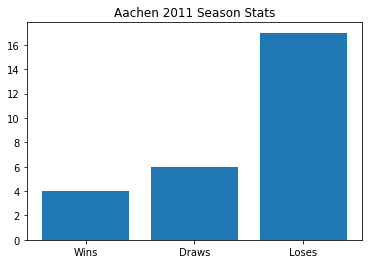

In [487]:
# Create histogram for each teams Wins, Draws and Loses

data = Stats_df.iloc[0].to_dict()
xaxis = list(data.keys())[2:]
y_values = list(data.values())[2:]

plt.bar(xaxis, y_values)
plt.title(list(data.values())[0] + ' 2011 Season Stats')
plt.show()

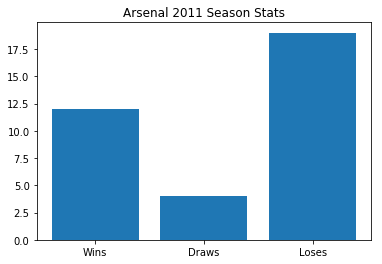

In [488]:
# Create histogram for each teams Wins, Draws and Loses

data = Stats_df.iloc[1].to_dict()
xaxis = list(data.keys())[2:]
y_values = list(data.values())[2:]

plt.bar(xaxis, y_values)
plt.title(list(data.values())[0] + ' 2011 Season Stats')
plt.show()

# MongoDB

In [ ]:
class MongoHandler:
    def __init__(self):
        self.myclient = pymongo.MongoClient()
        self.database = self.myclient['soccer_stats_database']
        self.collection = self.database['soccer_stats_collection']
        
    
    def insert_record(self):
        data = soccer_Team_Data_in_dict_Form #{'name': 'John Doe', 'address': '123 elm street', 'age': 28}
        record = self.collection.insert_one(data)

In [556]:
def create_histogram(ind):
    hist=None
    data = Stats_df.iloc[ind].to_dict()
    x_values = list(data.keys())[2:]
    y_values = list(data.values())[2:]
    
    hist = plt.bar(x_values, y_values)
    #plt.title(list(data.values())[0] + ' 2011 Season Stats')
    #return hist
    #print(ind)
    #print(data)
    #print(x_values)
    #print(y_values)
    return hist

<BarContainer object of 3 artists>

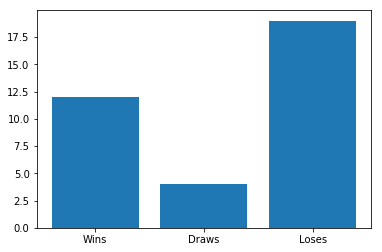

In [562]:
create_histogram(1)

In [565]:
def test(i):
    for i in range(2):
        histogram = create_histogram(i)
        
    

<BarContainer object of 3 artists>

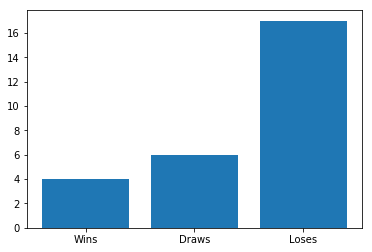

In [566]:
test(2)

{'team': 'Aachen', 'total_goals': 15, 'total_wins': 4, 'histogram': <BarContainer object of 3 artists>}
{'team': 'Arsenal', 'total_goals': 39, 'total_wins': 12, 'histogram': <BarContainer object of 3 artists>}


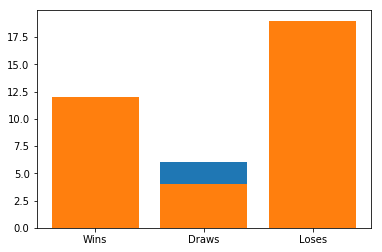

In [567]:
for i in range(2):
    histogram = create_histogram(i)
    stats_dict = {
        "team" : Stats_df.TeamName[i],
        "total_goals" : Stats_df.TotalGoals[i],
        "total_wins" : Stats_df.Wins[i],
        "histogram" : histogram    
    }
    print(stats_dict)

In [474]:
stats_dict["Arsenal"] 

KeyError: 'Arsenal'

In [455]:
type(stats_dict)

dict